The DICOM reading and display code is based on:

https://medium.com/@taposhdr/medical-image-analysis-with-deep-learning-i-23d518abf531


In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pydicom as pdicom
import os
import copy
import scipy.ndimage
import skimage.filters as skiFilt
from mpl_toolkits.axes_grid1 import ImageGrid
import time
from importlib import reload

from skimage.measure import label,regionprops, perimeter
from skimage.morphology import disk, dilation, remove_small_objects, erosion, closing, reconstruction, binary_closing
# from skimage.filters import roberts, sobel
# from skimage.filters import frangi, hessian


# from matplotlib import colors as mcolors
# from mpl_toolkits.axes_grid1 import ImageGrid

import frangix
# from frangi import frangi

reload(frangix)

%matplotlib inline

### Helper printing functions

`plti` - plots the provided image.  
`sample_stack` - plots every x slice of a 3D image stack  
`pltm` - creates a simple two column grid of the provided images  
`pltHist` - prints a histogram from the provided image or stack. Defaults to labeling as Hounsfield units

In [16]:
cmap = colors.ListedColormap(['black','white', 'green', 'red', 'blue', 'orange'])

In [17]:
def plti(im, h=8, title='',cmap='gray',**kwargs):
    y = im.shape[0]
    x = im.shape[1]
    w = (y/x) * h
    plt.figure(figsize=(w,h))
    plt.imshow(im, interpolation="none",cmap=cmap, **kwargs)
    plt.axis('off')
    plt.title(title)
    

In [18]:
def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3, size=12,cmap='gray'):
    fig,ax = plt.subplots(rows,cols,figsize=[size,size])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        if ind < stack.shape[2]:
            ax[int(i/cols),int(i % cols)].set_title('slice %d' % ind)
            ax[int(i/cols),int(i % cols)].imshow(stack[:,:,ind],cmap)
            ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()

In [19]:
def pltm(images,h=8,titles=[],cmap='gray'):
    
    imNum = len(images)
    imX   = (imNum+1)//2
    
    y = images[1].shape[0]
    x = images[1].shape[1]
    w = (y/x) * h
    
    fig = plt.figure(figsize=(w,h))
    grid = ImageGrid(fig, 111,             # similar to subplot(111)
                     nrows_ncols=(imX, 2), # creates 2x2 grid of axes
                     axes_pad=0.25,           # pad between axes in inch.
                     )

    for i in range(imNum):
        grid[i].imshow(images[i],cmap=cmap)  # The AxesGrid object work as a list of axes.
        grid[i].axis('off')
        grid[i].set_xticks([])
        grid[i].set_yticks([])
        if len(titles) > i :
            grid[i].set_title(titles[i])  
            
    plt.show()

In [20]:
def pltHist(image, bins=50,xlabel="Hounsfield Units (HU)",ylabel="Frequency", color='c'):

    plt.hist(image.flatten(), bins=bins, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


### Datafile Reading

This section provides the functions to read in the provided. These routines do the following:  
* Get a list of all the dicom (.dcm) files in the input directory
* Read the dicom header off the first file and save the dimensions and space
* Generate a matrix of each pixel's distance from 0, 0, 0 based in the dimensions and space obtained from the header
* Read the dicom files (one slice to a file)

In [21]:
# INPUT_FOLDER = '/Users/john/Programming/Work/AnnotatedScans/Pat1068Padded'
INPUT_FOLDER = '/Users/john/Programming/Work/Medtronic Samples/Pat002'
# INPUT_FOLDER = '/Users/john/Programming/Work/patient 1068'



In [22]:
def load_scan2(path):
    
    lstFilesDCM = []

    for dirName, subdirList, fileList in os.walk(path):
        for filename in fileList:
            if ".dcm" in filename.lower():
                lstFilesDCM.append(os.path.join(dirName,filename))
#                 print(lstFilesDCM)

    lstFilesDCM.sort()
    return lstFilesDCM


In [23]:
def GetSpacing(RefDs):

    #Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = np.asarray((int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM)+1))

    #Load spacing values (in mm)
    ConstPixelSpacing = np.asarray((float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness)))

    print('Pixel Dimensions: {}'.format(ConstPixelDims))
    print('Pixel Spacing:    {}'.format(ConstPixelSpacing))

    # print(RefDs.elements)
    
    return ConstPixelDims, ConstPixelSpacing


If you're interested in the measurement from 0,0,0 to any pixel, these arrays will show that. They're not currently used anywhere after this

In [24]:
def GenDimArray(ConstPixelDims, ConstPixelSpacing, doPrint=False):
    
    x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
    y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
    z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

    if doPrint:
        print(x,y,z)
        
    return x, y, z

In [25]:
def ReadDICOM(ConstPixelDims, lstFilesDCM, RefDs):

    # The array is sized based on 'ConstPixelDims'

    newDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

    # loop through all the DICOM files
    for filenameDCM in lstFilesDCM:
        # read the file
        ds = pdicom.read_file(filenameDCM)
        # Store the raw image data
        newDicom[:, :, pdicom.read_file(filenameDCM).InstanceNumber] = ds.pixel_array
    
    return newDicom


### Resampling

Use the metadata from the DICOM calculate the size of each voxel as the slice thickness and resampled into 1x1x1 mm pixels and slices.  

NOTE: When finished, the slices are normalized by subtracting off the min value of the entire stack (typically -1000)

In [26]:
def resample(image, spacing, new_spacing=[1,1,1]):

    resize_factor = new_spacing / spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

def shiftHouns(image):
    
    minH = np.min(image.flatten())
    image = image - minH
    return(image)


### Read the DICOM

This code sets up the segmentation code that follows by reading in the DICOM file and resizing it to 1 x 1 x 1mm.

Pixel Dimensions: [512 512 273]
Pixel Spacing:    [0.68164062 0.68164062 1.        ]


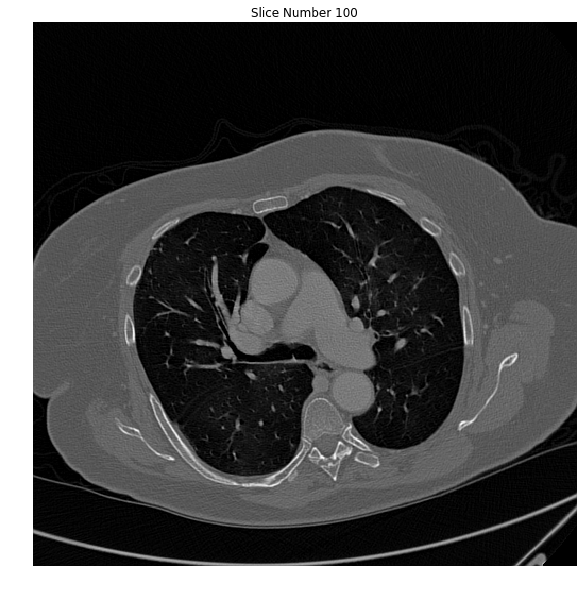

In [27]:
lstFilesDCM = load_scan2(INPUT_FOLDER)
lstFilesDCM.sort()
# print(lstFilesDCM)
    
RefDs = pdicom.read_file(lstFilesDCM[0])

ConstPixelDims, ConstPixelSpacing = GetSpacing(RefDs)
GenDimArray(ConstPixelDims, ConstPixelSpacing, False)

ArrayDicom = ReadDICOM(ConstPixelDims, lstFilesDCM, RefDs)

sliceNum = 100
plti(ArrayDicom[:, :, sliceNum],10,title = "Slice Number {}".format(sliceNum),cmap='gray')

# img_resampled, spacing = resample(ArrayDicom, ConstPixelSpacing, [1,1,1])

# print("Slice Thickness: %f" % ConstPixelSpacing[2])
# print("Pixel Spacing (row, col): (%f, %f) " % (ConstPixelSpacing[0], ConstPixelSpacing[1]))

# print("Shape before resampling\t", ArrayDicom.shape)
# print("Shape after resampling\t", img_resampled.shape)

# img_resampled = shiftHouns(img_resampled)

In [28]:
# Scan specific values:

# Pat1068
# maskLowCutoff = 2000

# Pat002
maskLowCutoff = 500


showSlice = 150

### 3D Segmentation

This is the same algorithm as that used for the 2D segmentation but for entire dicom stack. The primary changes are:
* `minAreaPct` defines how small a labeled 3D area must be considered as a useful area as a percentage of the total 3D volume
* `maxSizePct` defines how much big a labeled 3D object can be as measured by x and y dimensions as a percentage of the x and y slice dimensions
* Upon completion, the image labels are updated to remove rejected labels.

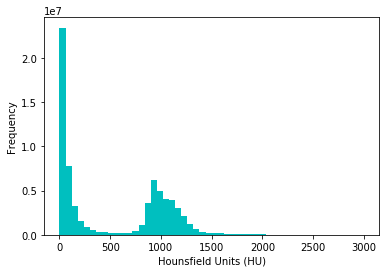

Hounsfield Units - Min:    0 Max: 3000
Labeling...
Getting initial areas
Total areas:  3716
Largest 10 areas: [8215, 8847, 8943, 11144, 49814, 142222, 475082, 1071422, 6527655, 22571222]
Removing small areas
Re-indexing remaining areas
Total remaining regions: 1
Largest 10 areas: [6527655]


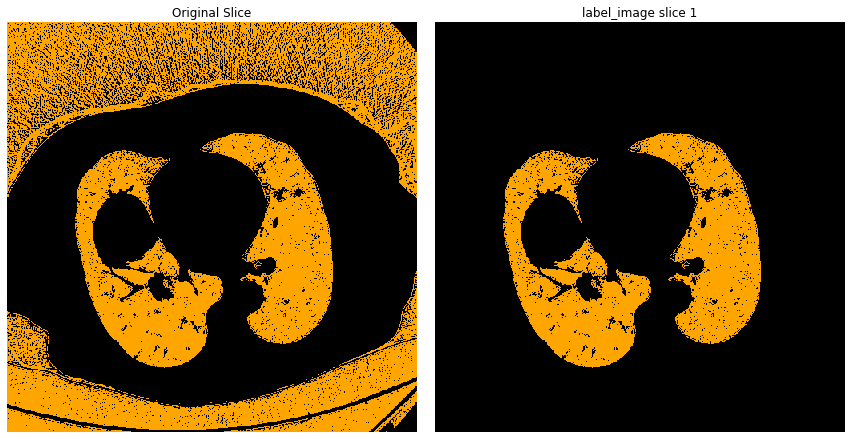

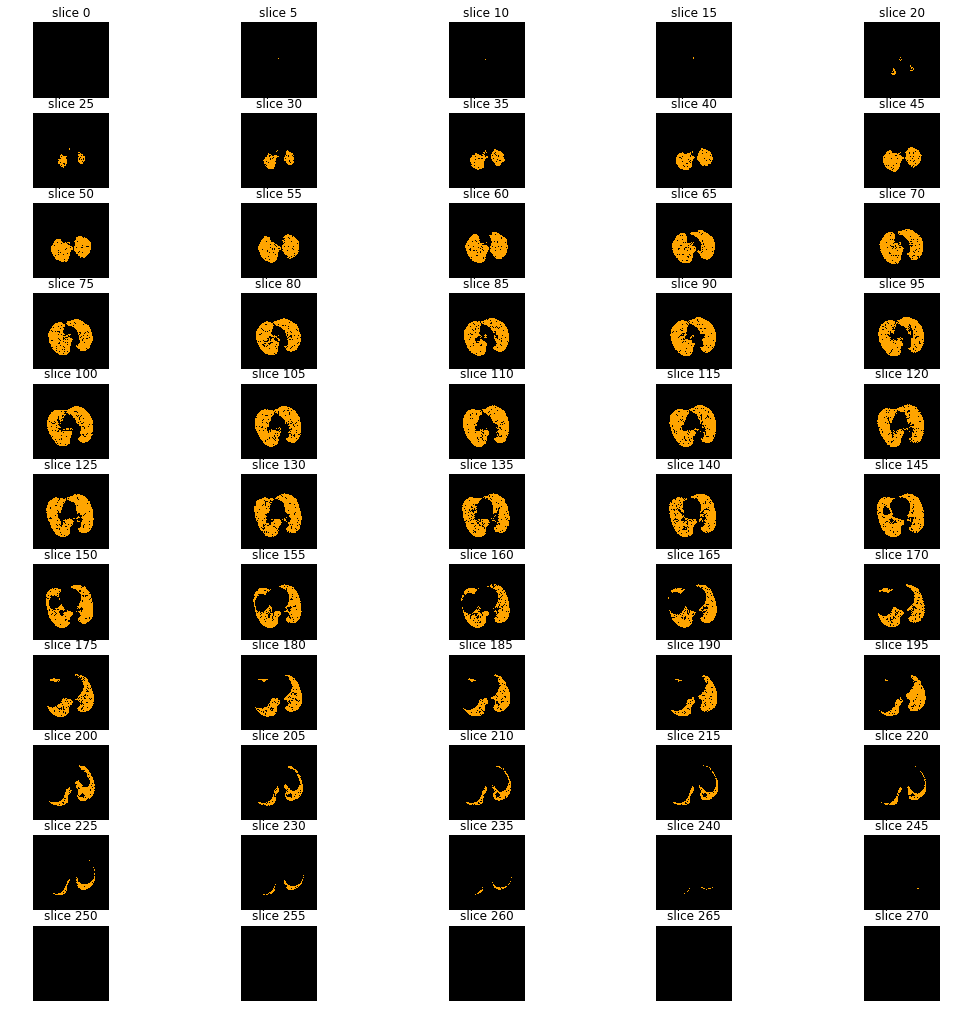

In [51]:
slice = copy.deepcopy(ArrayDicom[:, :, :])
slice[np.where(slice > 3000)] = 0

pltHist(slice)

# Convert to a binary mask after stripping off all the high Hounsfield values.
print('Hounsfield Units - Min: {:4d} Max: {:4d}'.format(np.min(slice),np.max(slice)))
slice[np.where(slice > maskLowCutoff)] = 0
slice[np.where(slice > 0)] = 1

print('Labeling...')
label_image = label(slice)

# Limits on area and size to get rid of things too big or too small
minAreaPct = 0.05
totalArea = slice.shape[0] * slice.shape[1] * slice.shape[2]
areaLimit = totalArea * minAreaPct
maxSizePct = 0.98
xMax = label_image.shape[0]*maxSizePct
yMax = label_image.shape[1]*maxSizePct

print('Getting initial areas')
areas = [r.area for r in regionprops(label_image)]
areas.sort()

topAreas = 10
print('Total areas: ',len(regionprops(label_image)))
print('Largest {} areas: {}'.format(topAreas,areas[-topAreas:]))

print('Removing small areas')
remainingRegions = []
for region in regionprops(label_image):
    xLen = region.bbox[3]-region.bbox[0]
    yLen = region.bbox[4]-region.bbox[1]
    if region.area < areaLimit or xLen > xMax or yLen > yMax :
        for coordinates in region.coords:
            label_image[coordinates[0], coordinates[1], coordinates[2]] = 0
    else:
        remainingRegions.append(region)

# This is some code to print one slice from each labeled area. It doesn't check to see if the object is actually
# in the slice being printed however.

# for region in remainingRegions:
#     tmp_image = copy.deepcopy(label_image)
#     tmp_label = region.label
#     for otherR in remainingRegions:
#         if otherR.label != tmp_label:
#             for coordinates in otherR.coords:
#                 tmp_image[coordinates[0], coordinates[1], coordinates[2]] = 0
#     plti(tmp_image[:,:,87],title = "tmp_label {}, bbox {}, area {}".format(tmp_label,region.bbox,region.area),cmap=cmap)
            

print('Re-indexing remaining areas')
finalRegions = []
areaX = []
idx = 1
for region in remainingRegions:
    region.label = idx
    finalRegions.append(region)
    areaX.append(region.area)
    for coordinates in region.coords:                
        label_image[coordinates[0], coordinates[1], coordinates[2]] = idx
    idx += 1

areas = [r.area for r in finalRegions]
print('Total remaining regions: {}'.format(len(finalRegions)))
print('Largest {} areas: {}'.format(topAreas,areas[-topAreas:]))

pltm([slice[:,:,showSlice],label_image[:,:,showSlice]],15,['Original Slice','label_image slice 1'],cmap=cmap)

stepSize = 5
show_image = label_image[:,:,:]
sample_stack(show_image, rows=int(np.ceil(show_image.shape[2]/5/stepSize)), cols=5, size=18, start_with=0, show_every=stepSize,cmap=cmap)

# sample_stack(label_image, rows=6, cols=8, size=15)



In [52]:
imgMask = label_image > 0

print(imgMask.shape)

selem = disk(10)

for i in range(imgMask.shape[2]):
    # Closure operation with disk of radius 12
    imgMask[:,:,i] = binary_closing(imgMask[:,:,i], selem)

    # Fill in the small holes inside the lungs
    edges = skiFilt.roberts(imgMask[:,:,i])
    imgMask[:,:,i] = scipy.ndimage.binary_fill_holes(edges)

# Superimpose the mask on the input image
imgLung = copy.deepcopy(ArrayDicom[:, :, :])
get_high_vals = imgMask == 0
imgLung[get_high_vals] = 0



(512, 512, 273)


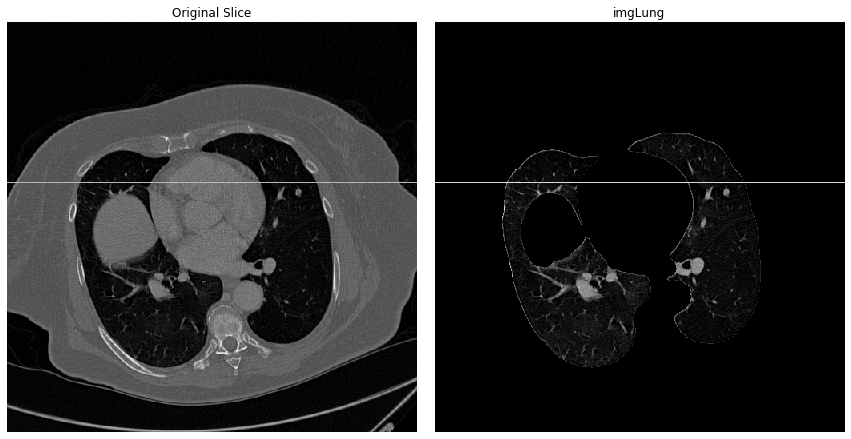

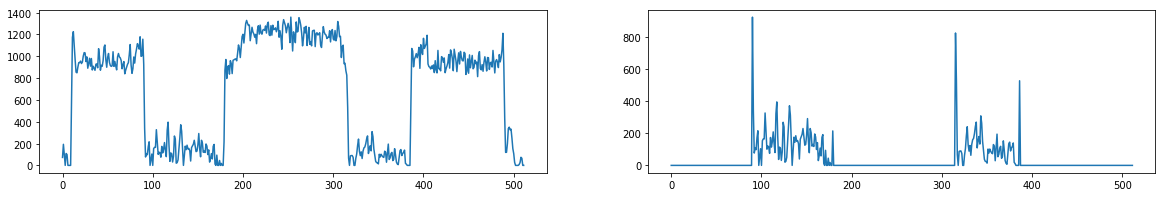

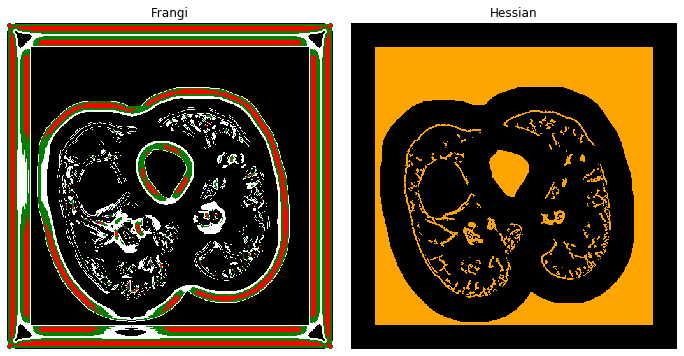

In [56]:
histLine = 200

histSlice = copy.deepcopy(ArrayDicom[:,:,showSlice])
histData = copy.deepcopy(histSlice[histLine,:])
histSlice[histLine,:] = 2000

imgSlice = copy.deepcopy(imgLung[:,:,showSlice])
imgData = copy.deepcopy(imgSlice[histLine,:])
imgSlice[histLine,:] = 2000

pltm([histSlice,imgSlice],15,['Original Slice','imgLung'],cmap='gray')

f = plt.figure(figsize=(20,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(histData)
ax2.plot(imgData)

hes = skiFilt.hessian(imgLung[:,:,showSlice])
frImg = skiFilt.frangi(hes)

pltm([frImg,hes],12,['Frangi','Hessian'],cmap=cmap) 


### Vesselness

This code looks at implementing the vesselness measurement from the Frangi paper. 

This section of code uses the frangi code from the net directly. Later sections import that code for ease of debug.

In [58]:
start_time = time.time()

vessels = frangix.frangi(imgLung[:,:,100:160], black_vessels=False)

end_time = time.time()

print(end_time - start_time)


f array start:  (5, 512, 512, 60) (5,) (512, 512, 60) (5, 512, 512, 60)
0 1
1 3
2 5
3 7
4 9
3 512 (5,) <class 'numpy.int64'>
f array end:    (5, 512, 512, 60)
xxx
50.61029815673828


150 50
(5, 512, 512, 60)


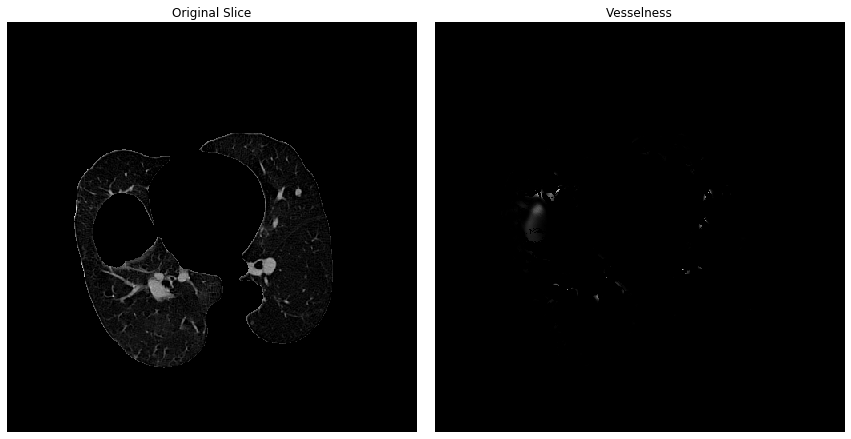

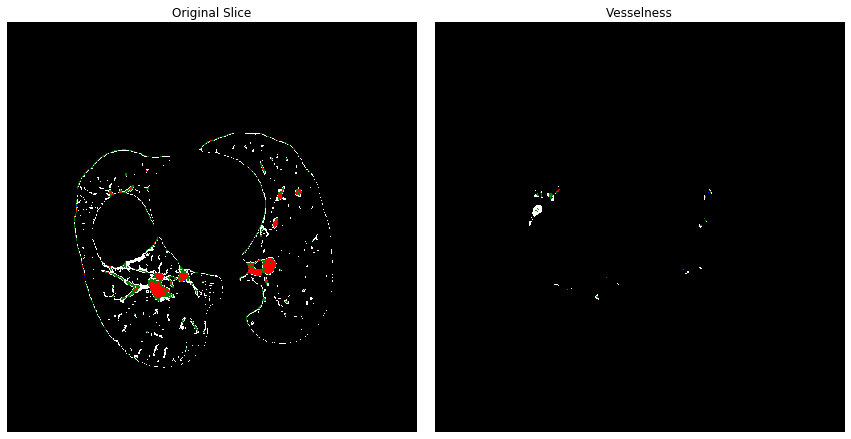

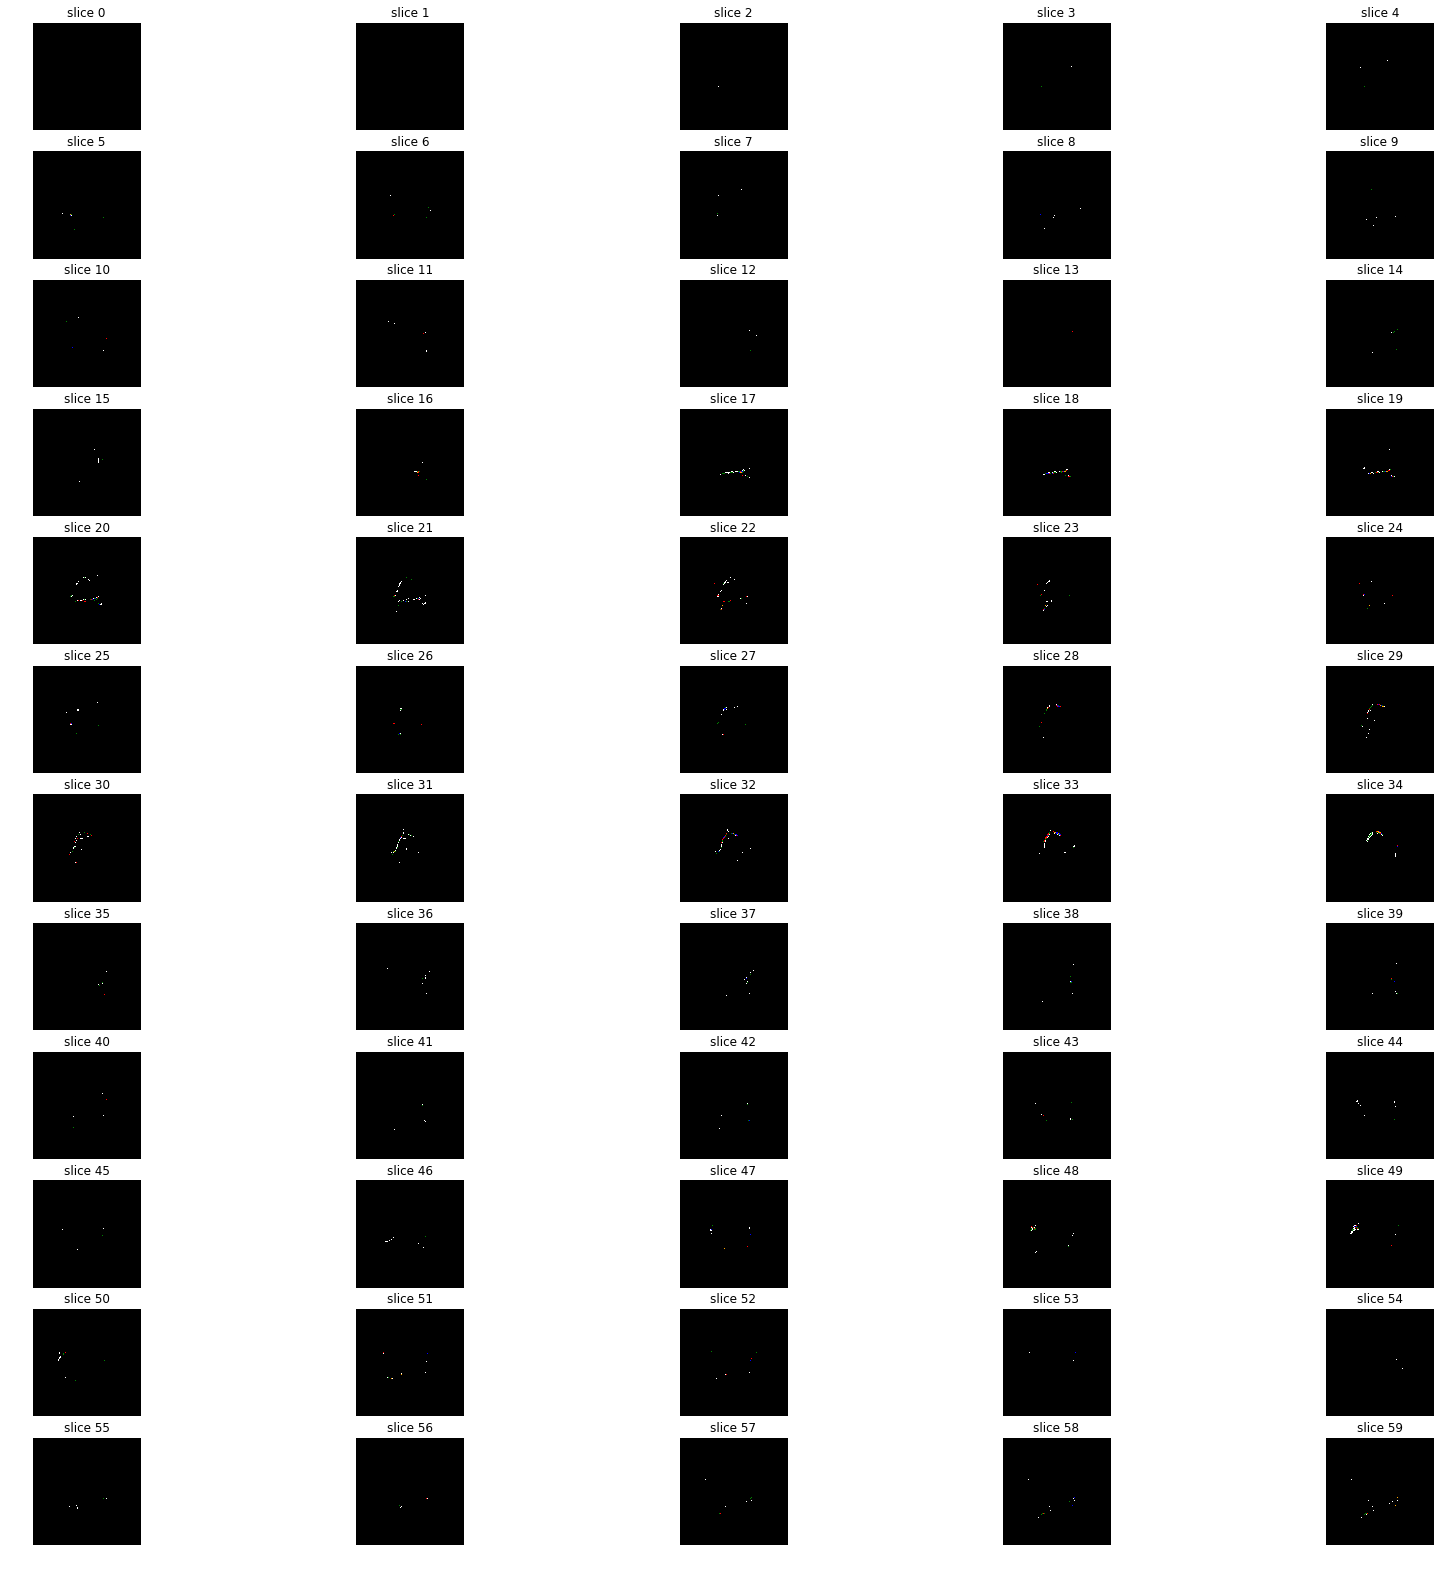

In [60]:
sNum = showSlice-100
print(showSlice, sNum)
#sNum = 24
print(vessels.shape)
pltm([imgLung[:,:,showSlice],vessels[1,:,:,sNum]],15,['Original Slice','Vesselness'],cmap='gray')
pltm([imgLung[:,:,showSlice],vessels[1,:,:,sNum]],15,['Original Slice','Vesselness'],cmap=cmap)

sample_stack(vessels[1], rows=12, cols=5, size=28, start_with=0, show_every=1,cmap=cmap)


Generating a gradient example. 

> y = np.array([1, 2, 4, 7, 11, 16], dtype=np.float)  
> j = np.gradient(y)  
> print('j = ',j)  
  
j = array([ 1. ,  1.5,  2.5,  3.5,  4.5,  5. ])  

Where those numbers come from:  

j[0] = (y[1]-y[0])/1 = (2-1)/1  = 1  
j[1] = (y[2]-y[0])/2 = (4-1)/2  = 1.5  
j[2] = (y[3]-y[1])/2 = (7-2)/2  = 2.5  
j[3] = (y[4]-y[2])/2 = (11-4)/2 = 3.5  
j[4] = (y[5]-y[3])/2 = (16-7)/2 = 4.5  
j[5] = (y[5]-y[4])/1 = (16-11)/1 = 5  

> j = np.gradient(y,x)  

x becomes a global divider of the gradients (e.g. x=2 results in all values of j/2)

This is the Hessian code from the Frangix file, loaded here for debug as stand alone code.

ndim 3


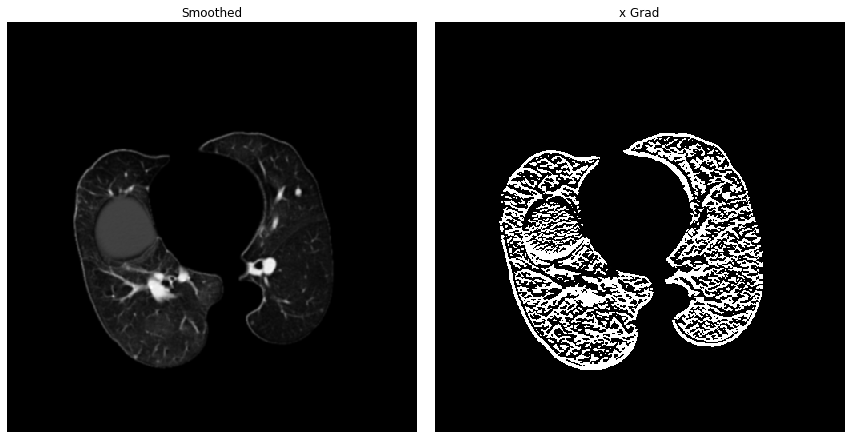

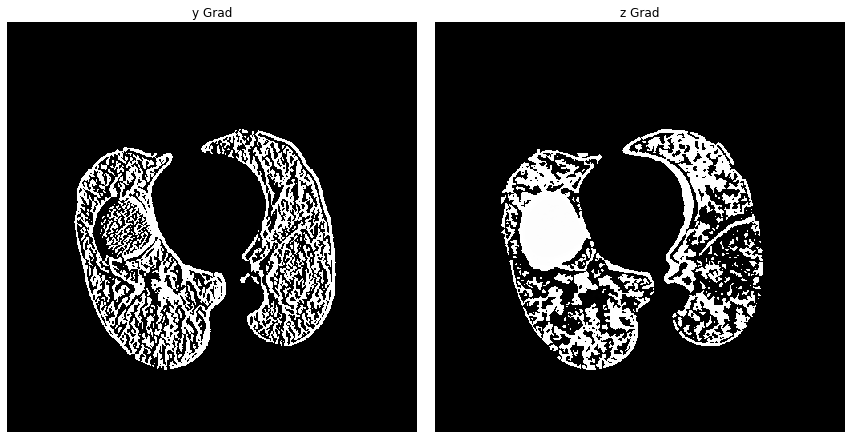

[[None, None, None], [None, None, None], [None, None, None]]
0 0 0
1 0 1
2 0 2
3 1 1
4 1 2
5 2 2


In [132]:
from itertools import combinations_with_replacement

ndim = imgLung.ndim
sigma = 1
scale = True

print('ndim',ndim)

# smooth the nd_array
smoothed = scipy.ndimage.gaussian_filter(imgLung, sigma=1)

# compute the first order gradients
gradient_list = np.gradient(smoothed)

# #   3 x 512 x 512 x 273 (3 axis over 512 x 512 slice x 273 slices)
# print((gradient_list[0][131][297][100:200]))

tmpX = gradient_list[0][:][:][:]
tmpY = gradient_list[1][:][:][:]
tmpZ = gradient_list[2][:][:][:]

pltm([smoothed[:,:,showSlice],tmpX[:,:,showSlice]],15,['Smoothed','x Grad'],cmap='gray')
pltm([tmpY[:,:,showSlice],tmpZ[:,:,showSlice]],15,['y Grad','z Grad'],cmap='gray')

# compute the hessian elements across all the unique combinations of dimensions (x-x, x-y, x-z, y-y, y-z, z-z)
hessian_elements = [np.gradient(gradient_list[ax0], axis=ax1)
                    for ax0, ax1 in combinations_with_replacement(range(ndim), 2)]

if sigma > 0 and scale:
    # scale the elements of the hessian matrix
    hessian_elements = [(sigma ** 2) * element for element in hessian_elements]

# create hessian matrix from hessian elements
hessian_full = [[None] * ndim] * ndim
print(hessian_full)

for index, (ax0, ax1) in enumerate(combinations_with_replacement(range(ndim), 2)):
    print(index, ax0, ax1)
    element = hessian_elements[index]
    hessian_full[ax0][ax1] = element
    if ax0 != ax1:
        hessian_full[ax1][ax0] = element

# At this point, hessian_full is filled as follows 
# [x-x x-y x-z]
# [y-x y-y y-z] 
# [z-x z-y z-z]

hessian_rows = list()
for row in hessian_full:
    hessian_rows.append(np.stack(row, axis=-1))

hessian = np.stack(hessian_rows, axis=-2)


hessian_elements
 len     :  6
 type [0]:  <class 'numpy.ndarray'>
 size [0]:  (512, 512, 273)
hessian_full
 len     :  3
 type: [0] <class 'list'>
 len   [0] 3
 type: [0][0] <class 'numpy.ndarray'>
 size  [0][0] (512, 512, 273)
hessian
 type:  <class 'numpy.ndarray'>
 size:  (512, 512, 273, 3, 3)


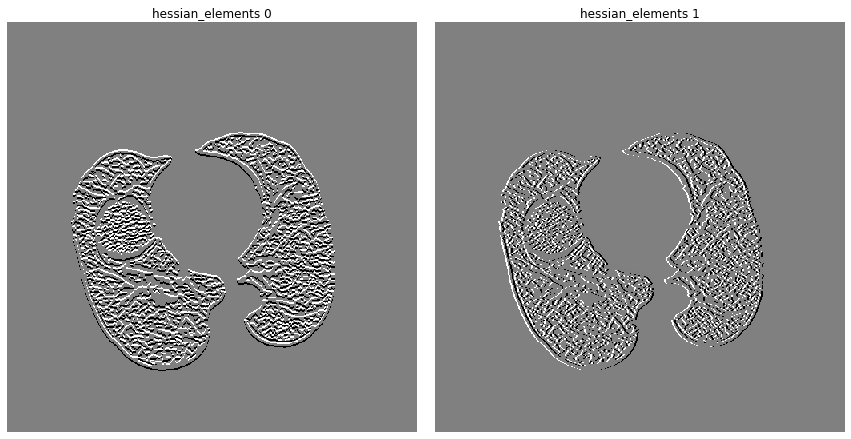

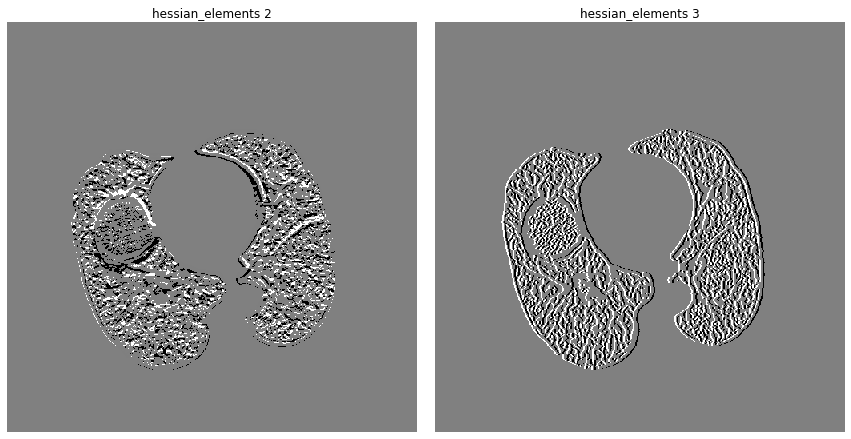

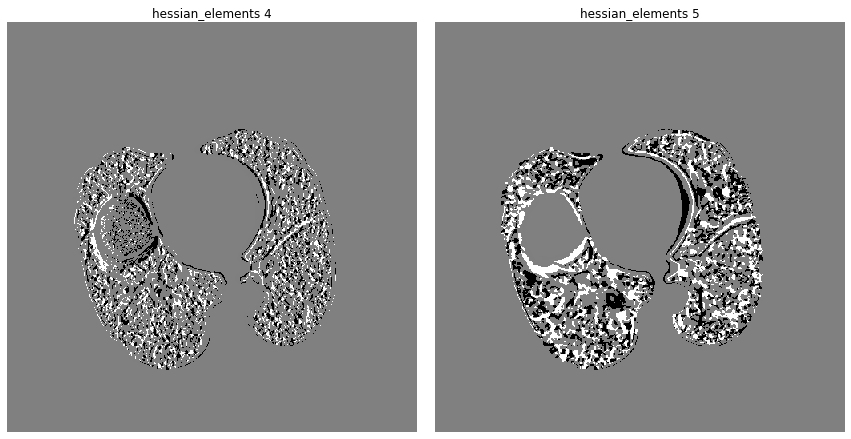

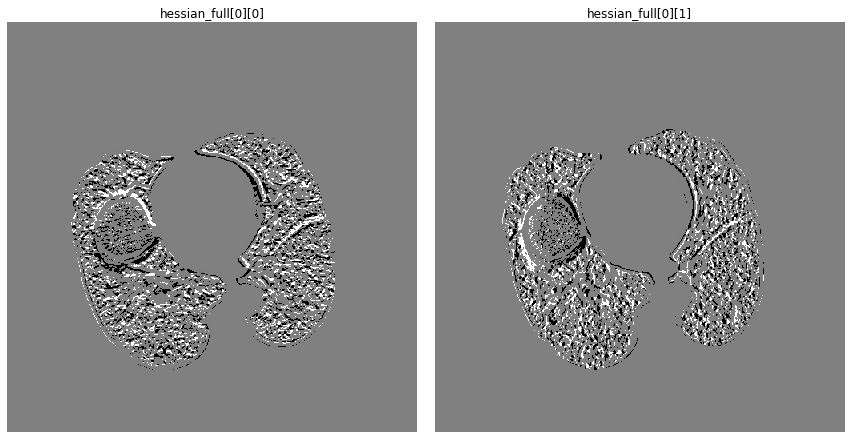

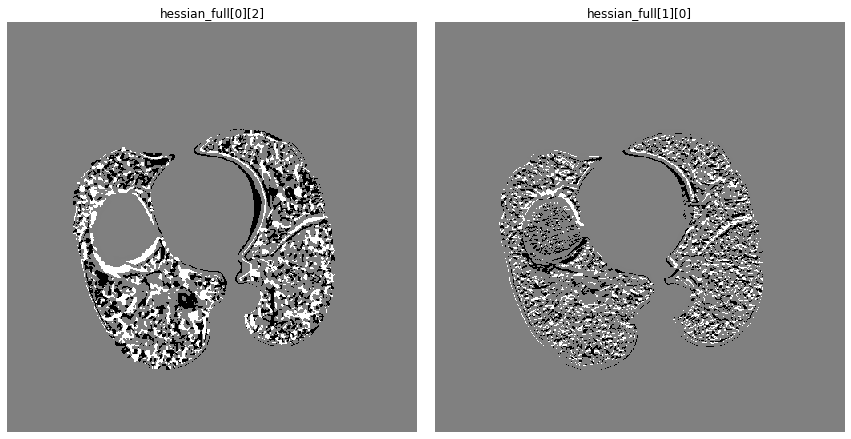

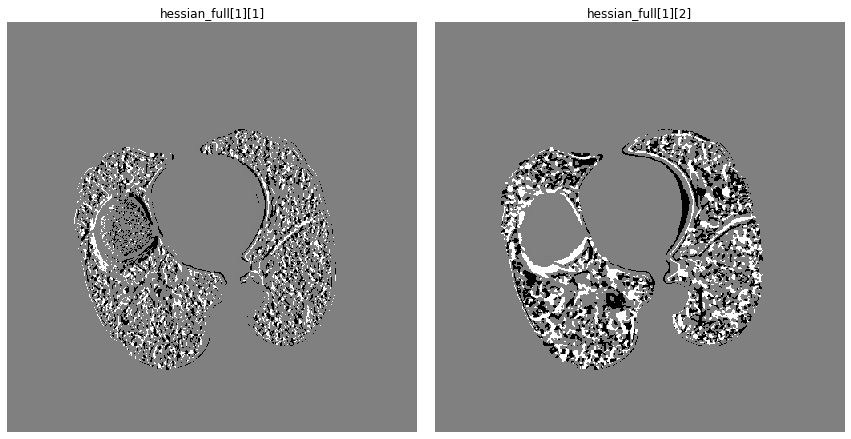

In [84]:
print('hessian_elements')
print(' len     : ',len(hessian_elements))
print(' type [0]: ',type(hessian_elements[0]))
print(' size [0]: ',hessian_elements[0].shape)

print('hessian_full')
print(' len     : ',len(hessian_full))
print(' type: [0]',type(hessian_full[0]))
print(' len   [0]',len(hessian_full[0]))
print(' type: [0][0]',type(hessian_full[0][0]))
print(' size  [0][0]',hessian_full[0][0].shape)

print('hessian')
print(' type: ',type(hessian))
print(' size: ',hessian.shape)

for i in range(0,len(hessian_elements),2):
    tmp1 = hessian_elements[i]
    tmp2 = hessian_elements[i+1]
    pltm([tmp1[:,:,showSlice],tmp2[:,:,showSlice]],15,['hessian_elements {}'.format(i),'hessian_elements {}'.format(i+1)],cmap='gray')

pltm([hessian_full[0][0][:,:,showSlice],hessian_full[0][1][:,:,showSlice]],15,['hessian_full[0][0]','hessian_full[0][1]'],cmap='gray')
pltm([hessian_full[0][2][:,:,showSlice],hessian_full[1][0][:,:,showSlice]],15,['hessian_full[0][2]','hessian_full[1][0]'],cmap='gray')
pltm([hessian_full[1][1][:,:,showSlice],hessian_full[1][2][:,:,showSlice]],15,['hessian_full[1][1]','hessian_full[1][2]'],cmap='gray')


In [107]:
def absolute_eigenvaluesh(nd_array):
    """
    Computes the eigenvalues sorted by absolute value from the symmetrical matrix.
    :param nd_array: array from which the eigenvalues will be calculated.
    :return: A list with the eigenvalues sorted in absolute ascending order (e.g. [eigenvalue1, eigenvalue2, ...])
    """
    eigenvalues = np.linalg.eigvalsh(nd_array)
#     sorted_eigenvalues = eigenvalues
    sorted_eigenvalues = sortbyabs(eigenvalues, axis=-1)
    return [np.squeeze(eigenvalue, axis=-1)
            for eigenvalue in np.split(sorted_eigenvalues, sorted_eigenvalues.shape[-1], axis=-1)]


def sortbyabs(a, axis=0):
    """Sort array along a given axis by the absolute value
    modified from: http://stackoverflow.com/a/11253931/4067734
    """
    index = list(np.ix_(*[np.arange(i) for i in a.shape]))
    index[axis] = np.abs(a).argsort(axis)
    return a[index]

eigVals = utils.absolute_eigenvaluesh(hessian)


65536.25003973753 -72555.3682204035
72555.3682204035 -65536.25003973753


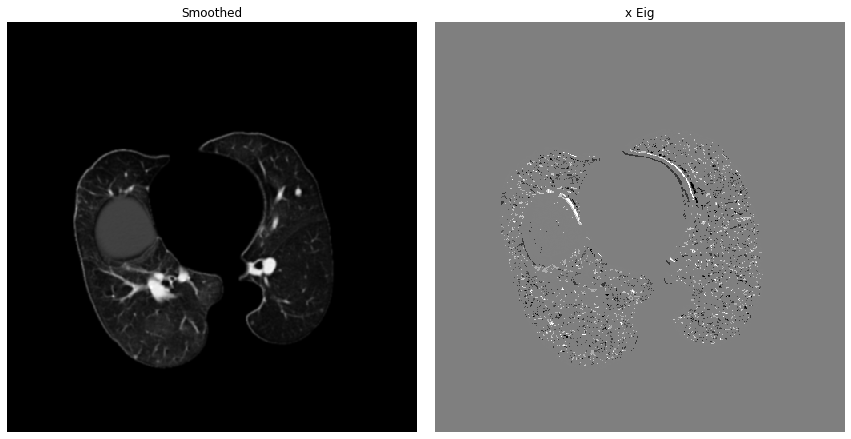

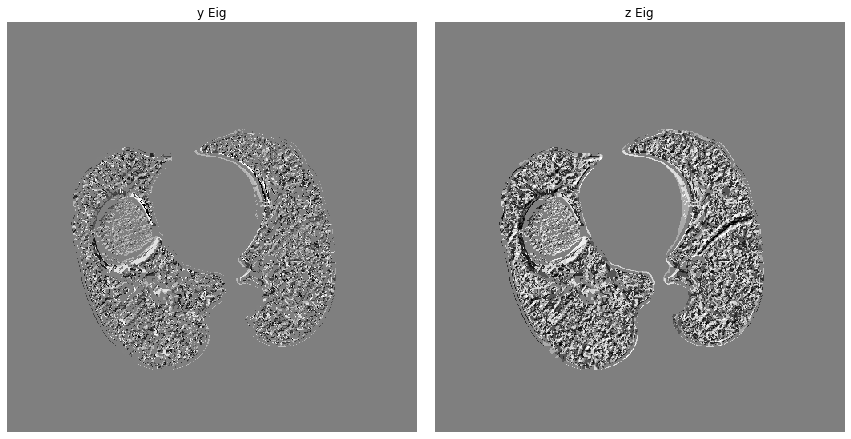

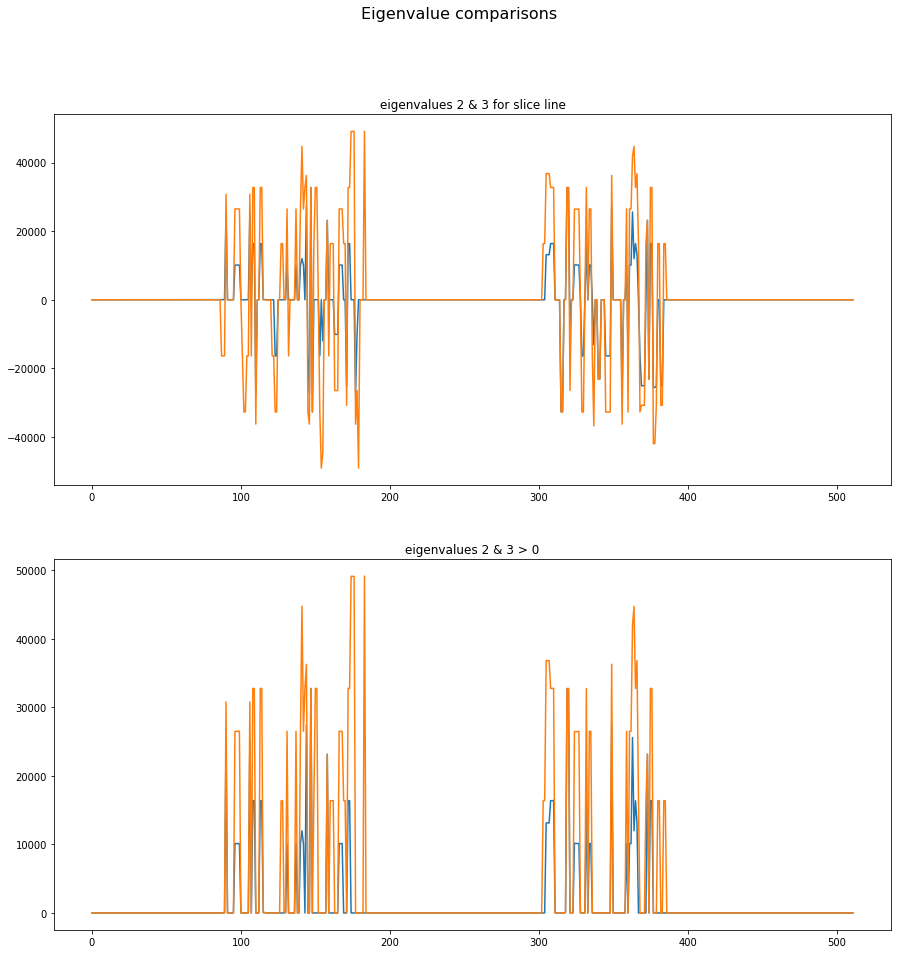

In [122]:
print(np.max(eigVals[2]),np.min(eigVals[2]))
eigVals[2] = np.negative(eigVals[2])
print(np.max(eigVals[2]),np.min(eigVals[2]))
aArray = np.array(eigVals)

pltm([smoothed[:,:,showSlice],aArray[0,:,:,showSlice]],15,['Smoothed','x Eig'],cmap='gray')
pltm([aArray[1,:,:,showSlice],aArray[2,:,:,showSlice]],15,['y Eig','z Eig'],cmap='gray')

histLine = 200

eig2Slice = copy.deepcopy(aArray[1,:,:,showSlice])
eig2Data = copy.deepcopy(eig2Slice[histLine,:])
eig2Slice[histLine,:] = 2000

eig3Slice = copy.deepcopy(aArray[2,:,:,showSlice])
eig3Data = copy.deepcopy(eig3Slice[histLine,:])
eig3Slice[histLine,:] = 2000

gtrZero2 = copy.deepcopy(eig2Data)
gtrZero2[eig2Data < 0] = 0 
gtrZero3 = copy.deepcopy(eig3Data)
gtrZero3[eig3Data < 0] = 0

fig, axs = plt.subplots(2,1,figsize=(15,15))
fig.suptitle('Eigenvalue comparisons', fontsize=16)

axs[0].plot(eig2Data, '-', eig3Data, '-')
axs[0].set_title('eigenvalues 2 & 3 for slice line')
axs[1].plot(gtrZero2, '-', gtrZero3, '-')
axs[1].set_title('eigenvalues 2 & 3 > 0')

plt.show()

The Frangi/Hessian code comes from:

https://github.com/ellisdg/frangi3d

Some modifications and additions based on the paper:

    van Dongen, E., & van Ginneken, B. (2010, April). Automatic segmentation of pulmonary vasculature in thoracic CT scans with local thresholding and airway wall removal. In 2010 IEEE International Symposium on Biomedical Imaging: From Nano to Macro (pp. 668-671). IEEE.

1. Replaced compute_vesselness with compute_vesselness2
2. Changed S calculation to remove eigenvalue 1  
3. Added V calculation



In [38]:
from itertools import combinations_with_replacement
import utils

import numpy as np
from scipy import ndimage as ndi

def compute_hessian_matrix(nd_array, sigma=1, scale=True):
    """
    Computes the hessian matrix for an nd_array.
    This can be used to detect vesselness as well as other features.

    In 3D the first derivative will contain three directional gradients at each index:
    [ gx,  gy,  gz ]

    The Hessian matrix at each index will then be equal to the second derivative:
    [ gxx, gxy, gxz]
    [ gyx, gyy, gyz]
    [ gzx, gzy, gzz]

    The Hessian matrix is symmetrical, so gyx == gxy, gzx == gxz, and gyz == gzy.

    :param nd_array: n-dimensional array from which to compute the hessian matrix.
    :param sigma: gaussian smoothing to perform on the array.
    :param scale: if True, the hessian elements will be scaled by sigma squared.
    :return: hessian array of shape (..., ndim, ndim)
    """
    ndim = nd_array.ndim
    plti(nd_array[:,:,150],10,title = "Slice Number {}".format(snum),cmap='gray')

    # smooth the nd_array
    smoothed = ndi.gaussian_filter(nd_array, sigma=sigma)

    # compute the first order gradients
    gradient_list = np.gradient(smoothed)

    # starting with the initial gradients, compute the second order gradients across all 
    # the unique combinations of dimensions (x-x, x-y, x-z, y-y, y-z, z-z)
    hessian_elements = [np.gradient(gradient_list[ax0], axis=ax1)
                        for ax0, ax1 in combinations_with_replacement(range(ndim), 2)]

    if sigma > 0 and scale:
        # scale the elements of the hessian matrix
        hessian_elements = [(sigma ** 2) * element for element in hessian_elements]

    # create hessian matrix from hessian elements
    hessian_full = [[None] * ndim] * ndim

    for index, (ax0, ax1) in enumerate(combinations_with_replacement(range(ndim), 2)):
        element = hessian_elements[index]
        hessian_full[ax0][ax1] = element
        if ax0 != ax1:
            hessian_full[ax1][ax0] = element

    hessian_rows = list()
    for row in hessian_full:
        hessian_rows.append(np.stack(row, axis=-1))

    # At this point, hessian_full is filled as follows 
    # [x-x x-y x-z]
    # [y-x y-y y-z] 
    # [z-x z-y z-z]

    hessian = np.stack(hessian_rows, axis=-2)
    return hessian


def absolute_hessian_eigenvalues(nd_array, sigma=1, scale=True):
    """
    Eigenvalues of the hessian matrix calculated from the input array sorted by absolute value.
    :param nd_array: input array from which to calculate hessian eigenvalues.
    :param sigma: gaussian smoothing parameter.
    :param scale: if True hessian values will be scaled according to sigma squared.
    :return: list of eigenvalues [eigenvalue1, eigenvalue2, ...]
    """
    return absolute_eigenvaluesh(compute_hessian_matrix(nd_array, sigma=sigma, scale=scale))


In [31]:
def compute_measures(eigen1, eigen2, eigen3):
    """
    RA - plate-like structures
    RB - blob-like structures
    S - background
    """
    Ra = utils.divide_nonzero(np.abs(eigen2), np.abs(eigen3))
    Rb = utils.divide_nonzero(np.abs(eigen1), np.sqrt(np.abs(np.multiply(eigen2, eigen3))))
#     S = np.sqrt(np.square(eigen1) + np.square(eigen2) + np.square(eigen3))
    S = np.sqrt(np.square(eigen2) + np.square(eigen3))
    return Ra, Rb, S


def compute_plate_like_factor(Ra, alpha):
    return 1 - np.exp(np.negative(np.square(Ra)) / (2 * np.square(alpha)))


def compute_blob_like_factor(Rb, beta):
    return np.exp(np.negative(np.square(Rb) / (2 * np.square(beta))))


def compute_background_factor(S, c):
    return 1 - np.exp(np.negative(np.square(S)) / (2 * np.square(c)))


In [49]:
def compute_vesselness(eigen1, eigen2, eigen3, alpha, beta, c, black_white):
    Ra, Rb, S = compute_measures(eigen1, eigen2, eigen3)

    plate = compute_plate_like_factor(Ra, alpha)
    blob = compute_blob_like_factor(Rb, beta)
    background = compute_background_factor(S, c)
    
    print('Shapes: Ra {} Plate {} blob {} Background {}'.format(Ra.shape,plate.shape,blob.shape,background.shape))
    snum = 150
    histLine = 200

    withBckgndSlice = copy.deepcopy((plate * blob * background)[:,:,snum])
    withBckgndData = copy.deepcopy(withBckgndSlice[histLine,:])
    withBckgndSlice[histLine,:] = 2000

    withoutBckgndSlice = copy.deepcopy((plate * blob)[:,:,snum])
    withoutBckgndData = copy.deepcopy(withoutBckgndSlice[histLine,:])
    withoutBckgndSlice[histLine,:] = 2000

    f = plt.figure(figsize=(20,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.plot(withBckgndData)
    ax2.plot(withoutBckgndData)

    pltm([Ra[:,:,snum],plate[:,:,snum]],15,['Ra','Plate'],cmap='gray')
    pltm([blob[:,:,snum],background[:,:,snum]],15,['Blob','Background'],cmap='gray')
    pltm([withBckgndSlice,withoutBckgndSlice],15,['w/bckgnd','wo/bckgnd'],cmap='gray')

    return filter_out_background(plate * blob * background, black_white, eigen2, eigen3)


def filter_out_background(voxel_data, black_white, eigen2, eigen3):
    """
    Set black_white to true if vessels are darker than the background and to false if
    vessels are brighter than the background.
    """
    pltHist(eigen2)
    pltHist(eigen3)
    pltHist(voxel_data)

    tmp1 = np.zeros_like(eigen2)
    tmp1[eigen2 > 0] = 1
    tmp2 = np.zeros_like(eigen3)
    tmp2[eigen3 > 0] = 1
    tmp3 = np.zeros_like(eigen2)
    tmp3[tmp1 == tmp2] = 255
    
    print('eigen comparisons')
    pltHist(tmp1)
    pltHist(tmp2)
    pltHist(tmp3)
    plti(tmp3[:, :, 150],10,title = "Slice Number {}".format(150),cmap='gray')
 
    if black_white:
        voxel_data[eigen2 < 0] = 0
        voxel_data[eigen3 < 0] = 0
    else:
        voxel_data[eigen2 > 0] = 0
        voxel_data[eigen3 > 0] = 0
    voxel_data[np.isnan(voxel_data)] = 0

    pltHist(voxel_data)

    return voxel_data



gen eigenvalues - Step 0, Sigma 1


/Users/john/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


65536.25003973753 -72555.3682204035
72555.3682204035 -65536.25003973753
compute vesselness
Shapes: Ra (512, 512, 273) Plate (512, 512, 273) blob (512, 512, 273) Background (512, 512, 273)


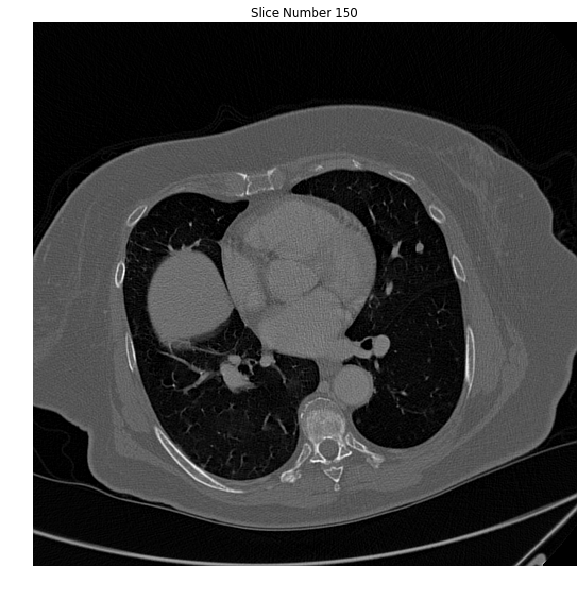

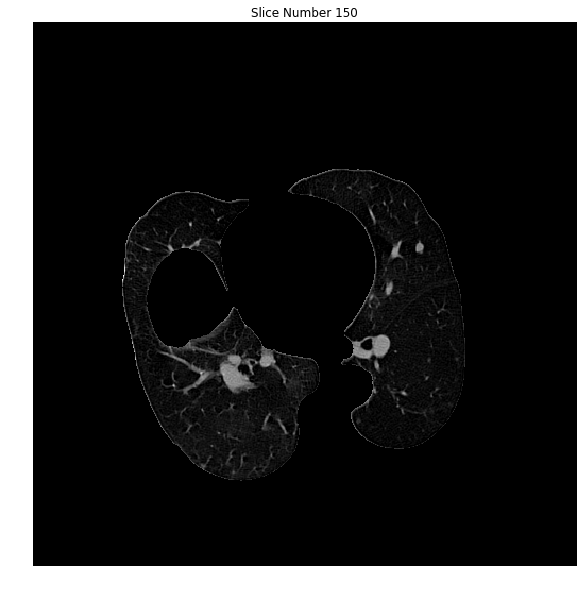

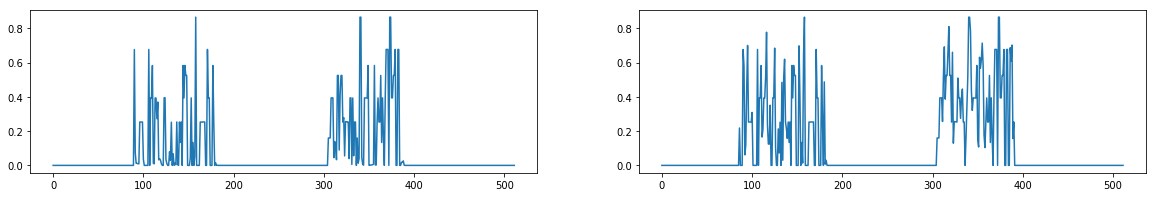

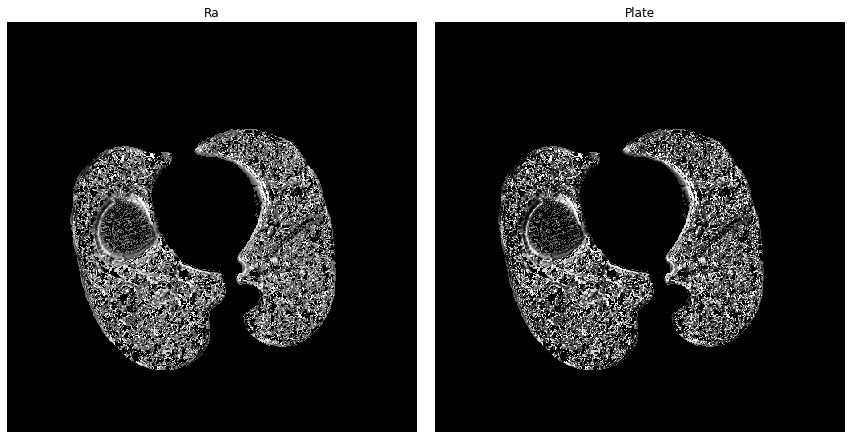

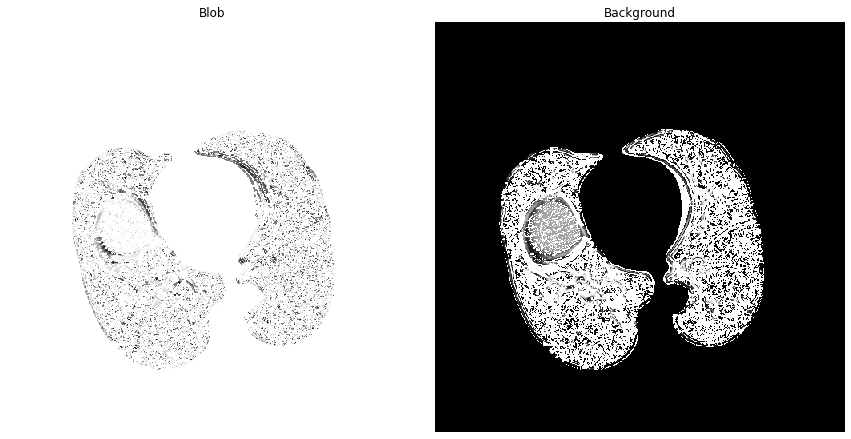

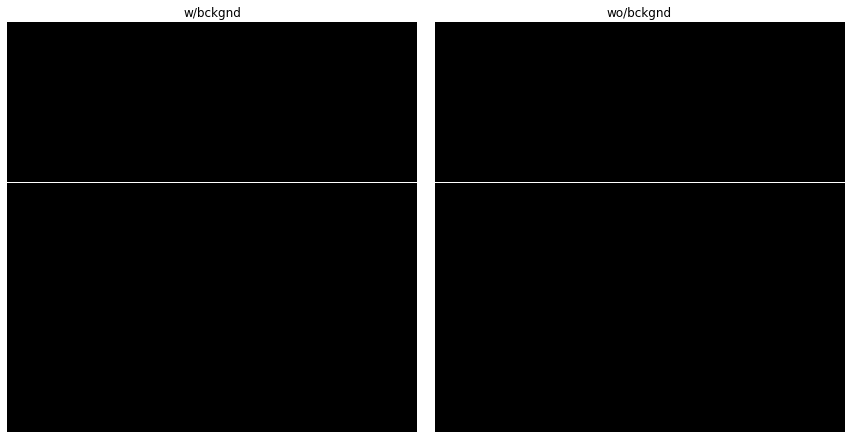

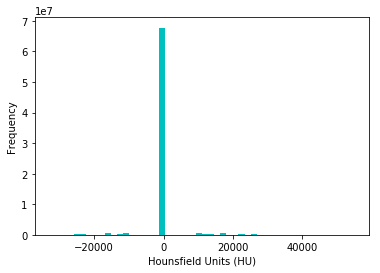

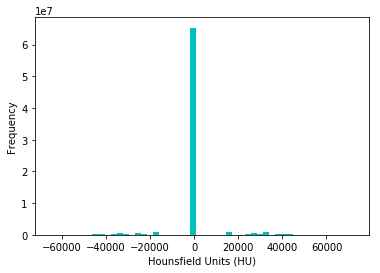

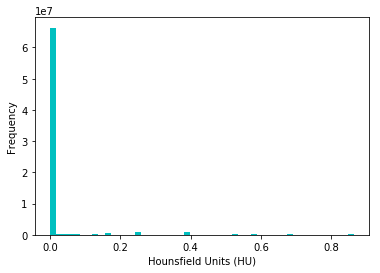

eigen comparisons


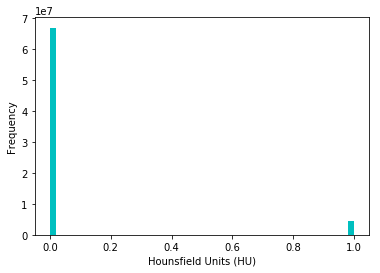

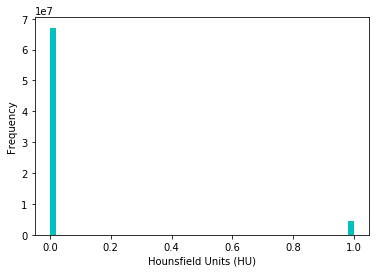

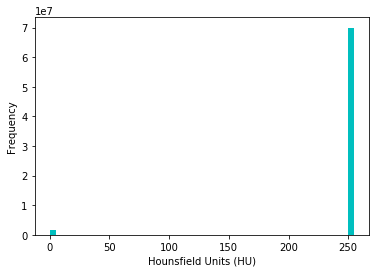

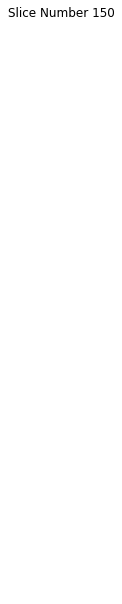

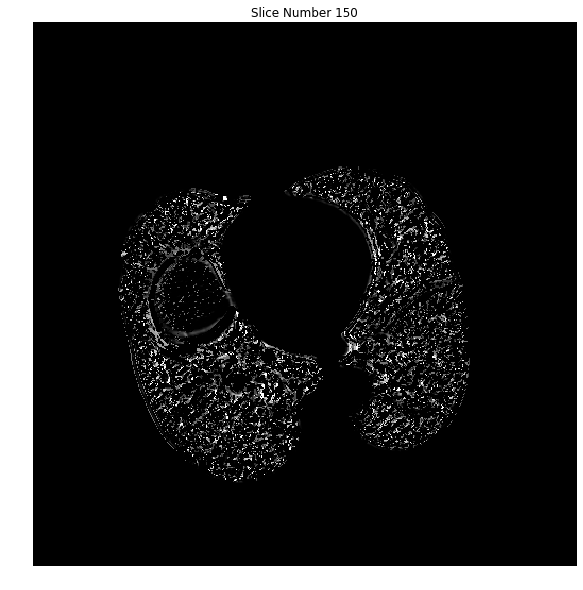

In [154]:
scale_range=(1, 10)
scale_step=2
alpha=0.5
beta=0.5
frangi_c=70
black_vessels=False

snum = 150

sigmas = np.arange(scale_range[0], scale_range[1], scale_step)
filtered_array = np.zeros(sigmas.shape + imgLung.shape)

plti(ArrayDicom[:, :, snum],10,title = "Slice Number {}".format(snum),cmap='gray')

for i, sigma in enumerate(sigmas):
    if i < 1:
        print('gen eigenvalues - Step {}, Sigma {}'.format(i,sigma))
        eigenvalues = absolute_hessian_eigenvalues(imgLung, sigma=sigma, scale=True)

        print(np.max(eigenvalues[2]),np.min(eigenvalues[2]))
        eigenvalues[2] = np.negative(eigenvalues[2])
        print(np.max(eigenvalues[2]),np.min(eigenvalues[2]))

        
        print('compute vesselness')
        filtered_array[i] = compute_vesselness(*eigenvalues, alpha=alpha, beta=beta, c=frangi_c,black_white=black_vessels)
        plti(filtered_array[i,:,:,snum],10,title = "Slice Number {}".format(snum),cmap='gray')




In [ ]:
snum = 150
print(filtered_array.shape)
pltm([filtered_array[0,:,:,snum],filtered_array[1,:,:,snum]],15,['filtered_array[0]','filtered_array[1]'],cmap='gray')
pltm([filtered_array[2,:,:,snum],filtered_array[3,:,:,snum]],15,['filtered_array[2]','filtered_array[3]'],cmap='gray')

print(len(eigenvalues))

In [151]:
def hessianCalc(x):
    """
    Calculate the hessian matrix with finite differences
    Parameters:
       - x : ndarray
    Returns:
       an array of shape (x.dim, x.ndim) + x.shape
       where the array[i, j, ...] corresponds to the second derivative x_ij
    """
    x_grad = np.gradient(x) 
    hessian = np.empty(x.shape + (x.ndim, x.ndim), dtype=x.dtype) 
    for k, grad_k in enumerate(x_grad):
        # iterate over dimensions
        # apply gradient again to every component of the first derivative.
        tmp_grad = np.gradient(grad_k) 
        for l, grad_kl in enumerate(tmp_grad):
            hessian[:, :, :, k, l] = grad_kl
    return hessian

x = np.random.randn(100, 100, 100)
hess2 = hessianCalc(imgLung)
print(hess2.shape)
print(hessian.shape)

# for i in range(0,hess2.shape[0]):
#     for j in range(0,hess2.shape[1]):
#         pltm([hessian[:,:,showSlice,i,j],hess2[:,:,showSlice,i,j]],15,['hessian_elements {}'.format(i),'hessian_elements {}'.format(i+1)],cmap='gray')


(512, 512, 273, 3, 3)
(512, 512, 273, 3, 3)


gen eigenvalues - Step 0, Sigma 1


/Users/john/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


196599.66672544283 -92679.07160734833
92679.07160734833 -196599.66672544283
compute vesselness
Shapes: Ra (512, 512, 273) Plate (512, 512, 273) blob (512, 512, 273) Background (512, 512, 273)


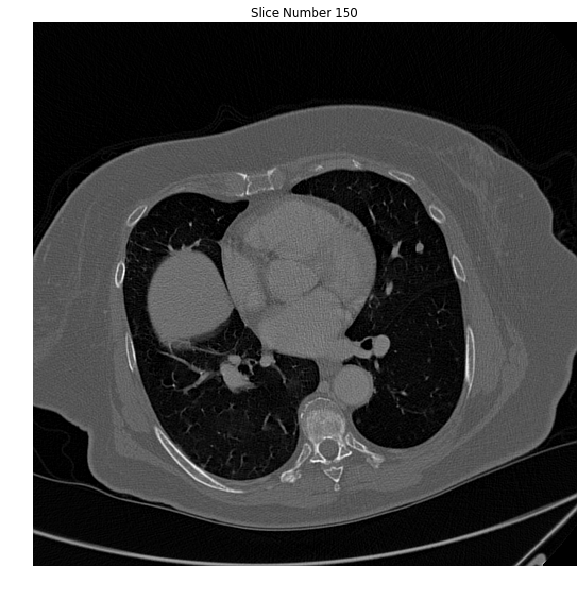

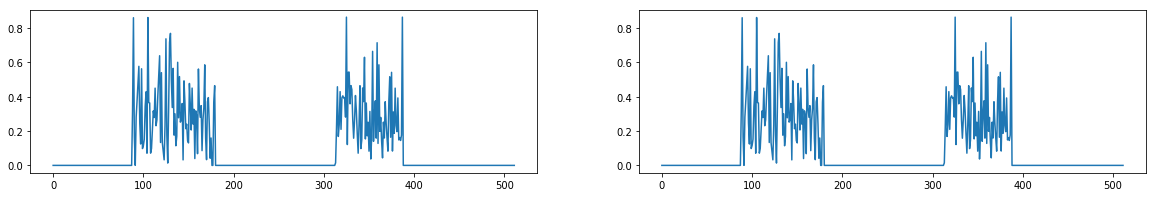

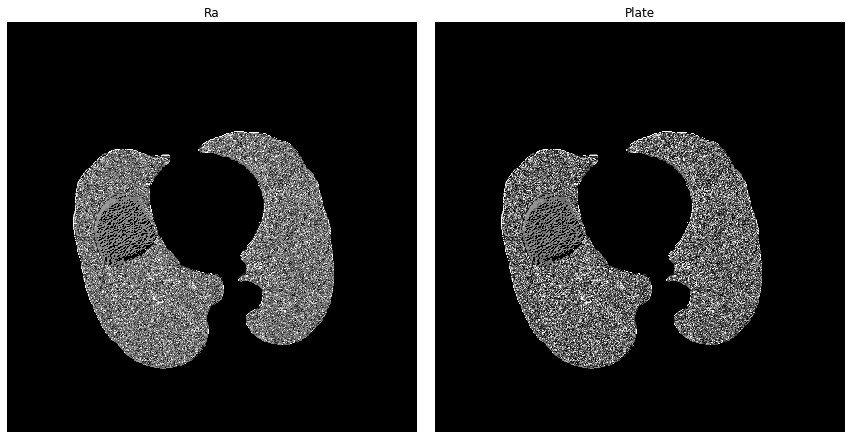

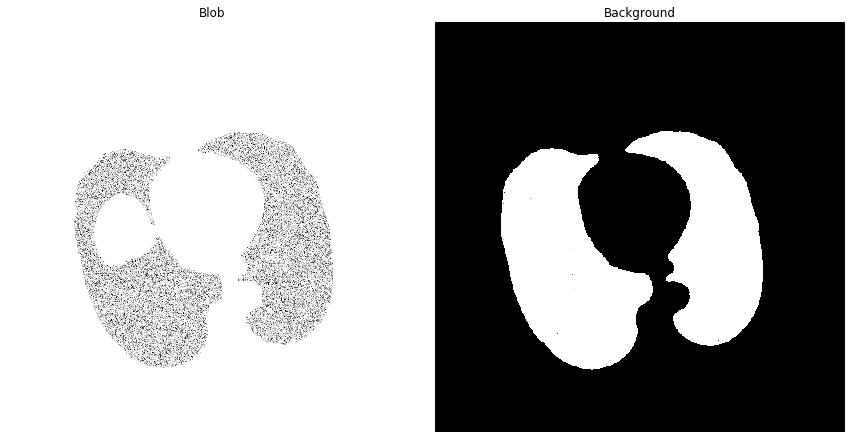

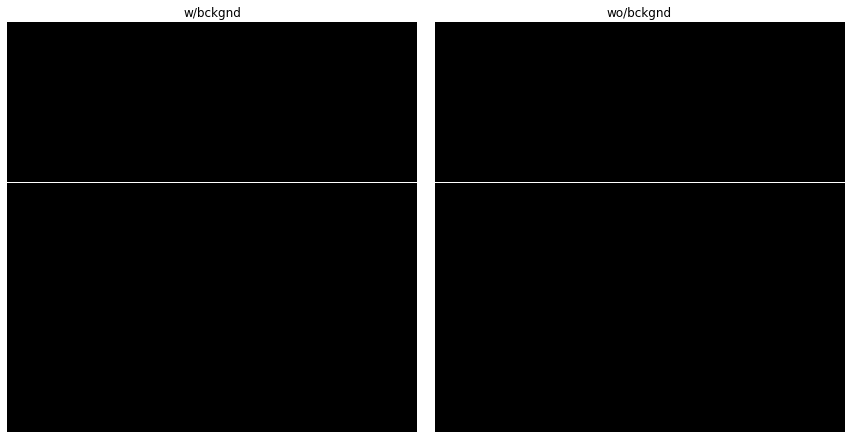

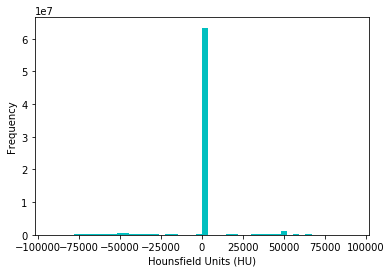

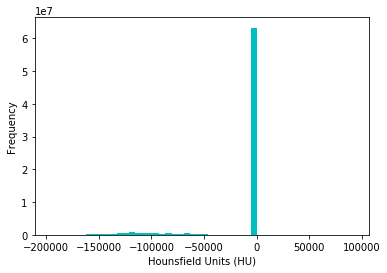

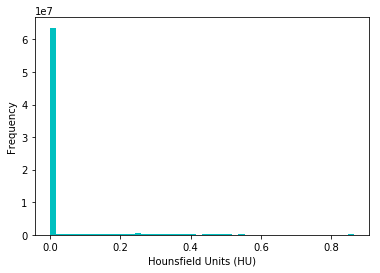

eigen comparisons


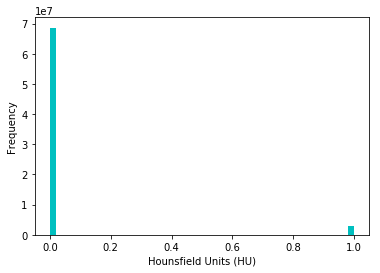

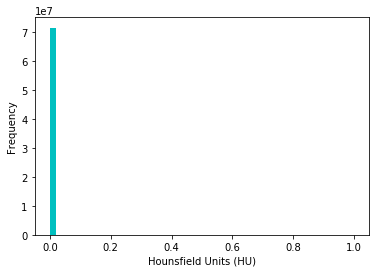

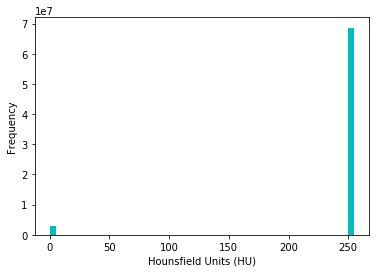

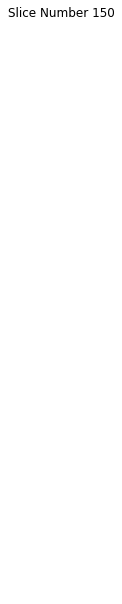

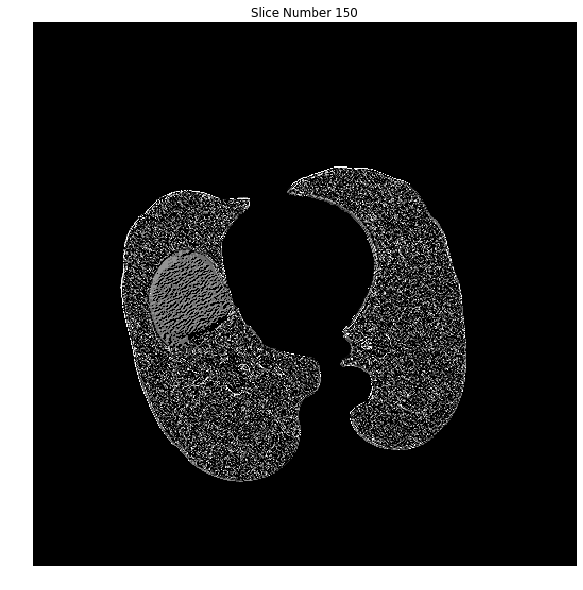

In [153]:
scale_range=(1, 10)
scale_step=2
alpha=0.5
beta=0.5
frangi_c=70
black_vessels=False

snum = 150

sigmas = np.arange(scale_range[0], scale_range[1], scale_step)
filtered_array = np.zeros(sigmas.shape + ArrayDicom.shape)

plti(ArrayDicom[:, :, snum],10,title = "Slice Number {}".format(snum),cmap='gray')

for i, sigma in enumerate(sigmas):
    if i < 1:
        print('gen eigenvalues - Step {}, Sigma {}'.format(i,sigma))
        eigenvalues = absolute_eigenvaluesh(hess2)

        print(np.max(eigenvalues[2]),np.min(eigenvalues[2]))
        eigenvalues[2] = np.negative(eigenvalues[2])
        print(np.max(eigenvalues[2]),np.min(eigenvalues[2]))

        
        print('compute vesselness')
        filtered_array[i] = compute_vesselness(*eigenvalues, alpha=alpha, beta=beta, c=frangi_c,black_white=black_vessels)
        plti(filtered_array[i,:,:,snum],10,title = "Slice Number {}".format(snum),cmap='gray')

